# 0. Importing Necessary Packages

In [38]:
%set_env PATH=/root/anaconda3/bin:/root/anaconda3/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/root/.fzf./bin

env: PATH=/root/anaconda3/bin:/root/anaconda3/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/root/.fzf./bin


In [39]:
# Printing the information of Python, IPython, OS, and the generation date.
%load_ext version_information
%version_information
%matplotlib inline

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


In [40]:
# Printing the versions of packages
from importlib_metadata import version
for pkg in ['numpy', 'matplotlib', 'astropy', 'pandas']:
    print(pkg+": ver "+version(pkg))

numpy: ver 1.18.1
matplotlib: ver 3.1.3
astropy: ver 4.0
pandas: ver 1.0.1


In [41]:
# matplotlib backend
%matplotlib notebook

# importing necessary modules
import numpy as np
import glob, os
from matplotlib import pyplot as plt
from astropy.io import fits
import pandas as pd
from acstools import acszpt
from reproject import reproject_interp

In [42]:
from email.utils import decode_rfc2231
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy import units as u


from scipy import stats 

In [43]:
colnames_cat = ['id', 'RA','Dec', 'x', 'y', 'fwhm', 
'area', 'stel', 'ell', 'theta', 'nf5sig', 'nfobs', 'f435w_mag', 'f435w_magerr',
'f435w_flux', 'f435w_fluxerr', 'f435w_fluxnJy', 'f435w_fluxnJyerr', 'f435w_sig', 'f606w_mag', 'f606w_magerr', 'f606w_flux', 
'f606w_fluxerr' , 'f606w_fluxnJy', 'f606w_fluxnJyerr', 'f606w_sig', 'f814w_mag', 'f814w_magerr', 'f814w_flux', 'f814w_fluxerr', 
'f814w_fluxnJy', 'f814w_fluxnJyerr' , 'f814w_sig' , 'f105w_mag', 'f105w_magerr', 'f105w_flux', 'f105w_fluxerr', 'f105w_fluxnJy', 
'f105w_fluxnJyerr', 'f105w_sig', 'f125w_mag', 'f125w_magerr', 'f125w_flux', 'f125w_fluxerr', 'f125w_fluxnJy', 'f125w_fluxnJyerr', 'f125w_sig', 
'f140w_mag', 'f140w_magerr', 'f140w_flux', 'f140w_fluxerr', 'f140w_fluxnJy', 'f140w_fluxnJyerr', 'f140w_sig', 'f160w_mag', 'f160w_magerr', 'f160w_flux',
'f160w_fluxerr', 'f160w_fluxnJy', 'f160w_fluxnJyerr', 'f160w_sig', 'bright_mag', 'bright_magerr', 'zb', 'zbmin', 'zbmax', 'tb', 'odds', 'chisq', 
'chisq2', 'M0', 'zml', 'tml'] 
colnames = ['x','y','num','mag_auto','merr_auto','mag_iso','merr_iso','mag_isocor', 'magerr_isocor','kron','backgr','ra','dec',
            'a','b','theta','mu0','flag','fwhm','flxrad','cl']

In [44]:
def galextcor(data, wavelength):
    EBV = 0.1893
    if wavelength == "F390W":
        data['mag_iso'] = data['mag_iso'] - (4.514 * EBV)
        return data
    elif wavelength == "F435W":
        data['mag_iso'] = data['mag_iso'] - (4.117 * EBV)
        return data
    elif wavelength == "F475W":
        data['mag_iso'] = data['mag_iso'] - (3.747 * EBV)
        return data
    elif wavelength == "F555W":
        data['mag_iso'] = data['mag_iso'] - (3.242 * EBV)
        return data
    elif wavelength == "F606W":
        data['mag_iso'] = data['mag_iso'] - (2.929 * EBV)
        return data
    elif wavelength == "F625W":
        data['mag_iso'] = data['mag_iso'] - (2.671 * EBV)
        return data
    elif wavelength == "F775W":
        data['mag_iso'] = data['mag_iso'] - (2.018 * EBV)
        return data
    elif wavelength == "F814W":
        data['mag_iso'] = data['mag_iso'] - (1.847 * EBV)
        return data
    elif wavelength == "F850LP":
        data['mag_iso'] = data['mag_iso'] - (1.473 * EBV)
        return data
    elif wavelength == "F105W":
        data['mag_iso'] = data['mag_iso'] - (1.015 * EBV)
        return data
    elif wavelength == "F110W":
        data['mag_iso'] = data['mag_iso'] - (0.876 * EBV)
        return data
    elif wavelength == "F125W":
        data['mag_iso'] = data['mag_iso'] - (0.757 * EBV)
        return data
    elif wavelength == "F140W":
        data['mag_iso'] = data['mag_iso'] - (0.609 * EBV)
        return data
    elif wavelength == "F160W":
        data['mag_iso'] = data['mag_iso'] - (0.470 * EBV)
        return data
    else:
        print("wrong input")

In [45]:
class matchingsexcat:
    def __init__(self, dat_sex, dat_catalog):  # def __init__(self, dat_sex, dat_catalog, tolerance)
        tol = 0.2 / 3600 # tol = tolerance / 3600
        ra_s, dec_s = dat_sex['ra'], dat_sex['dec']
        ra_c, dec_c = dat_catalog['RA'], dat_catalog['Dec']
        src = SkyCoord(ra=ra_s*u.degree, dec=dec_s*u.degree)    # coordinates from SExtractor
        cat = SkyCoord(ra=ra_c*u.degree, dec=dec_c*u.degree)    # coordinates from catalogs
        idx, sep2d, dist3d = match_coordinates_sky(src, cat, nthneighbor=1, storekdtree='kdtree_sky')    # 매칭 함수 실행

        matched = sep2d.value < tol    # 매칭 조건 적용
        self.n_mch = np.sum(matched)    # 매칭된 개수
        self.idx_cat = idx[matched]    # cat의 매칭된 인덱스
        self.idx_src = np.where(matched)[0]    # src의 매칭된 인덱스

    def matchedsex(self, dat_sex):
        return dat_sex[self.idx_src]

    def matchedsex_index(self):
        return self.idx_src

    def matchedcat(self, dat_catalog):
        return dat_catalog[self.idx_cat]

    def matchedcat_index(self):
        return self.idx_cat

    def matchedsize(self):
        return self.n_mch

class matchingsexsex:  # Sextractor Output 2개 끼리 서로 서로 매칭하는 코드 
    def __init__(self, dat_sex1, dat_sex2):  # def __init__(self, dat_sex1, dat_sex2, tolerance)
        tol = 0.1 / 3600 # tol = tolerance / 3600
        ra_s, dec_s = dat_sex1['ra'], dat_sex1['dec']
        ra_c, dec_c = dat_sex2['ra'], dat_sex2['dec']
        src = SkyCoord(ra=ra_s*u.degree, dec=dec_s*u.degree)    # coordinates from SExtractor
        cat = SkyCoord(ra=ra_c*u.degree, dec=dec_c*u.degree)    # coordinates from SExtractor2
        idx, sep2d, dist3d = match_coordinates_sky(src, cat, nthneighbor=1, storekdtree='kdtree_sky')    # 매칭 함수 실행

        matched = sep2d.value < tol    # 매칭 조건 적용
        self.n_mch = np.sum(matched)    # 매칭된 개수
        self.idx_cat = idx[matched]    # cat의 매칭된 인덱스
        self.idx_src = np.where(matched)[0]    # src의 매칭된 인덱스

    def matchedsex(self, dat_sex1):
        return dat_sex1[self.idx_src]

    def matchedsex_index(self):
        return self.idx_src

    def matchedcat(self, dat_sex2):
        return dat_sex2[self.idx_cat]

    def matchedcat_index(self):
        return self.idx_cat

    def matchedsize(self):
        return self.n_mch


# 1. F105W-F160W

In [46]:
dat_cat = np.genfromtxt('../1st_TASK_Relics_SMACS/catalog/hlsp_relics_hst_wfc3ir_smacs0723-73_multi_v1_cat.txt', dtype=None, encoding='ascii', names=colnames_cat)
dat_0 = np.genfromtxt( '/data/jip/1st_TASK_Relics_SMACS/Analysis-Result/60mas/F105W-F160W/Threshold_Low/F105W.cat', dtype=None, encoding='ascii', names=colnames)
dat_1 = np.genfromtxt('/data/jip/1st_TASK_Relics_SMACS/Analysis-Result/60mas/F105W-F160W/Threshold_Low/F160W.cat', dtype=None, encoding='ascii', names=colnames)

# dat_0 = np.genfromtxt( '/data/jip/1st_TASK_Relics_SMACS/F105W.cat', dtype=None, encoding='ascii', names=colnames)
# dat_1 = np.genfromtxt( '/data/jip/1st_TASK_Relics_SMACS/F160W.cat', dtype=None, encoding='ascii', names=colnames)


band = ["F105W", "F160W"]
band_catread = ["f105w", "f160w"]

# dat_0, dat_1, dat_cat = satlim(dat_0), satlim(dat_1), satlim(dat_cat)
dat_0 = galextcor(dat_0, "F105W")
dat_1 = galextcor(dat_1, "F160W")

#======================= Data에서 바로 Matching 

matched_F105W = matchingsexcat(dat_0, dat_cat).matchedsex(dat_0)
matched_F160W = matchingsexcat(dat_1, dat_cat).matchedsex(dat_1)
matched_Cat = matchingsexcat(dat_0, dat_cat).matchedcat(dat_cat)

#======================== Raw Data에서 point/Extended source 나눠서 라벨링

pointsource_sex = dat_0['cl']>0.6
pointsource_cat = dat_cat['stel']>0.6 #matached_Cat
extendedsource_sex = dat_0['cl']<0.6
extendedsource_cat = dat_cat['stel']<0.6 #matached_Cat

dat_0_pointsource = dat_0[pointsource_sex]
dat_0_extendedsource = dat_0[extendedsource_sex]
dat_1_pointsource = dat_1[pointsource_sex]
dat_1_extendedsource = dat_1[extendedsource_sex]

dat_cat_pointsource = dat_cat[pointsource_cat] #matached_Cat
dat_cat_extendedsource = dat_cat[extendedsource_cat] #matched_cat


#============= point / extended source 나눠서 matching ===============
matched_F105W_point = matchingsexcat(dat_0_pointsource, dat_cat_pointsource).matchedsex(dat_0_pointsource)
matched_F105W_extended = matchingsexcat(dat_0_extendedsource, dat_cat_extendedsource).matchedsex(dat_0_extendedsource)
matched_F160W_point = matchingsexcat(dat_1_pointsource, dat_cat_pointsource).matchedsex(dat_1_pointsource)
matched_F160W_extended = matchingsexcat(dat_1_extendedsource, dat_cat_extendedsource).matchedsex(dat_1_extendedsource)

matched_cat_point = matchingsexcat(dat_0_pointsource, dat_cat_pointsource).matchedcat(dat_cat_pointsource)
matched_cat_extended = matchingsexcat(dat_0_extendedsource, dat_cat_extendedsource).matchedcat(dat_cat_extendedsource)


#=============== Unmatched Output / Catalog 분리
F105Wmatch = [] 
for i in range(np.size(dat_0)):
    if dat_0[i] not in matched_F105W:
        F105Wmatch.append(i)

unmatched_F105W = dat_0[F105Wmatch]

F160Wmatch = [] 
for i in range(np.size(dat_1)):
    if dat_1[i] not in matched_F160W:
        F160Wmatch.append(i)

unmatched_F160W = dat_1[F160Wmatch]

catmatch = [] 
for i in range(np.size(dat_cat)):
    if dat_cat[i] not in matched_Cat:
        catmatch.append(i)

unmatched_Cat = dat_cat[catmatch]


In [47]:
%matplotlib inline

## 1) Raw Data

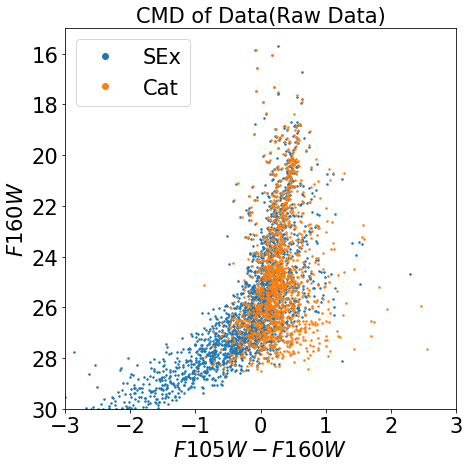

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.plot(dat_0['mag_iso']-dat_1['mag_iso'], dat_1['mag_iso'], 'o', ms = 1.5, label = 'SEx')
ax.plot(dat_cat['f105w_mag']-dat_cat['f160w_mag'], dat_cat['f160w_mag'], 'o', ms = 1.5, label='Cat')
ax.set_title('CMD of Data(Raw Data)', fontsize=21)
ax.tick_params(axis='x', labelsize=21)
ax.tick_params(axis='y', labelsize=21)
ax.set_xlabel('$F105W - F160W$', fontsize=21)
ax.set_ylabel('$F160W$', fontsize=21)
ax.set_xlim([-3, 3])
ax.set_ylim([30, 15])
lgnd0 = ax.legend(prop={'size':21})
lgnd0.legendHandles[0]._legmarker.set_markersize(6)
lgnd0.legendHandles[1]._legmarker.set_markersize(6)

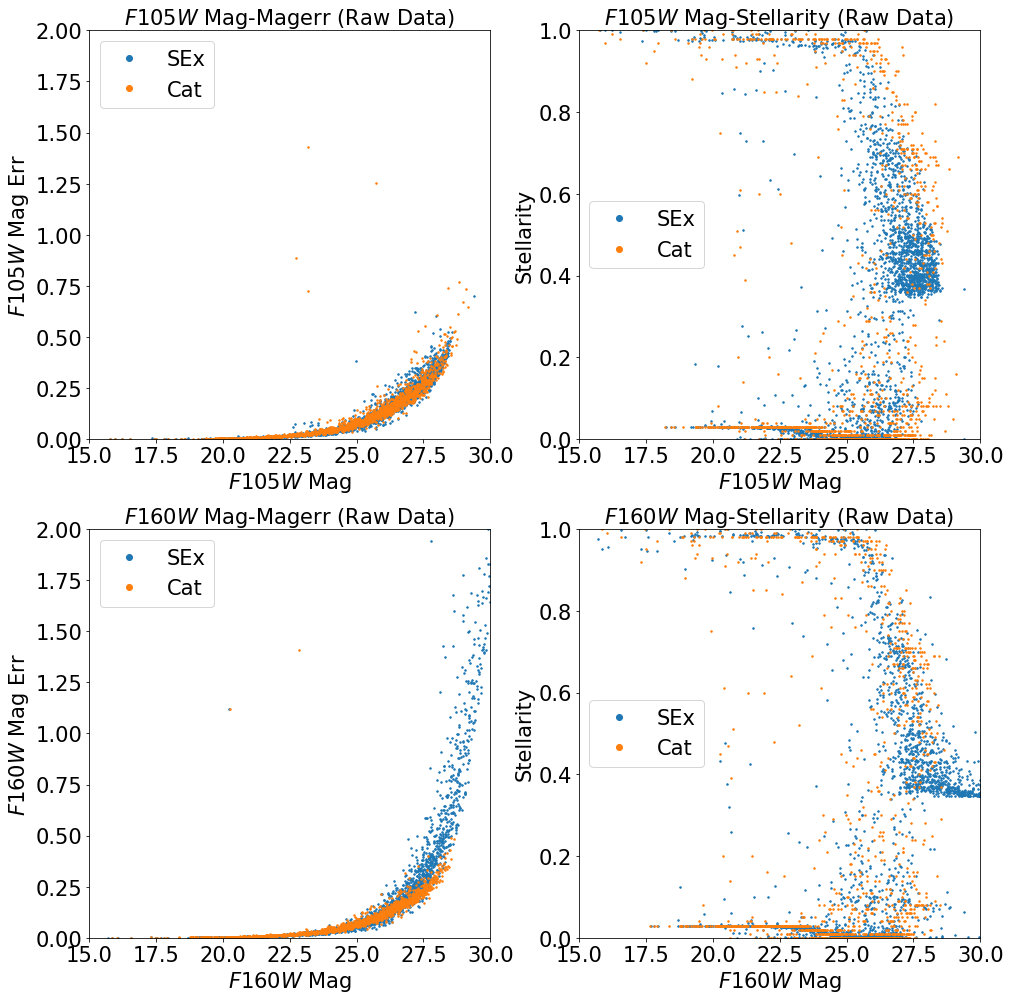

In [49]:
fig, ax = plt.subplots(2, 2, figsize=(14, 14))
ax[0,0].plot(dat_0['mag_iso'], dat_0['merr_iso'], 'o', ms = 1.5, label = 'SEx')
ax[0,0].plot(dat_cat['f105w_mag'], dat_cat['f105w_magerr'], 'o', ms = 1.5, label='Cat')
ax[0,0].set_title('$F105W$ Mag-Magerr (Raw Data)', fontsize=21)
ax[0,0].tick_params(axis='x', labelsize=21)
ax[0,0].tick_params(axis='y', labelsize=21)
ax[0,0].set_xlabel('$F105W$ Mag', fontsize=21)
ax[0,0].set_ylabel('$F105W$ Mag Err', fontsize=21)
ax[0,0].set_xlim([15, 30])
ax[0,0].set_ylim([0, 2])
lgnd0 = ax[0,0].legend(prop={'size':21})
lgnd0.legendHandles[0]._legmarker.set_markersize(6)
lgnd0.legendHandles[1]._legmarker.set_markersize(6)

ax[0,1].plot(dat_0['mag_iso'], dat_0['cl'], 'o', ms = 1.5, label = 'SEx')
ax[0,1].plot(dat_cat['f105w_mag'], dat_cat['stel'], 'o', ms = 1.5, label='Cat')
ax[0,1].set_title('$F105W$ Mag-Stellarity (Raw Data)', fontsize=21)
ax[0,1].tick_params(axis='x', labelsize=21)
ax[0,1].tick_params(axis='y', labelsize=21)
ax[0,1].set_xlabel('$F105W$ Mag', fontsize=21)
ax[0,1].set_ylabel('Stellarity', fontsize=21)
ax[0,1].set_xlim([15, 30])
ax[0,1].set_ylim([0, 1])
lgnd1 = ax[0,1].legend(prop={'size':21})
lgnd1.legendHandles[0]._legmarker.set_markersize(6)
lgnd1.legendHandles[1]._legmarker.set_markersize(6)

ax[1,0].plot(dat_1['mag_iso'], dat_1['merr_iso'], 'o', ms = 1.5, label = 'SEx')
ax[1,0].plot(dat_cat['f160w_mag'], dat_cat['f160w_magerr'], 'o', ms = 1.5, label='Cat')
ax[1,0].set_title('$F160W$ Mag-Magerr (Raw Data)', fontsize=21)
ax[1,0].tick_params(axis='x', labelsize=21)
ax[1,0].tick_params(axis='y', labelsize=21)
ax[1,0].set_xlabel('$F160W$ Mag', fontsize=21)
ax[1,0].set_ylabel('$F160W$ Mag Err', fontsize=21)
ax[1,0].set_xlim([15, 30])
ax[1,0].set_ylim([0, 2])
lgnd2 = ax[1,0].legend(prop={'size':21})
lgnd2.legendHandles[0]._legmarker.set_markersize(6)
lgnd2.legendHandles[1]._legmarker.set_markersize(6)

ax[1,1].plot(dat_1['mag_iso'], dat_1['cl'], 'o', ms = 1.5, label = 'SEx')
ax[1,1].plot(dat_cat['f160w_mag'], dat_cat['stel'], 'o', ms = 1.5, label='Cat')
ax[1,1].set_title('$F160W$ Mag-Stellarity (Raw Data)', fontsize=21)
ax[1,1].tick_params(axis='x', labelsize=21)
ax[1,1].tick_params(axis='y', labelsize=21)
ax[1,1].set_xlabel('$F160W$ Mag', fontsize=21)
ax[1,1].set_ylabel('Stellarity', fontsize=21)
ax[1,1].set_xlim([15, 30])
ax[1,1].set_ylim([0, 1])
lgnd2 = ax[1,1].legend(prop={'size':21})
lgnd2.legendHandles[0]._legmarker.set_markersize(6)
lgnd2.legendHandles[1]._legmarker.set_markersize(6)


plt.tight_layout()


## 2) Matched Source

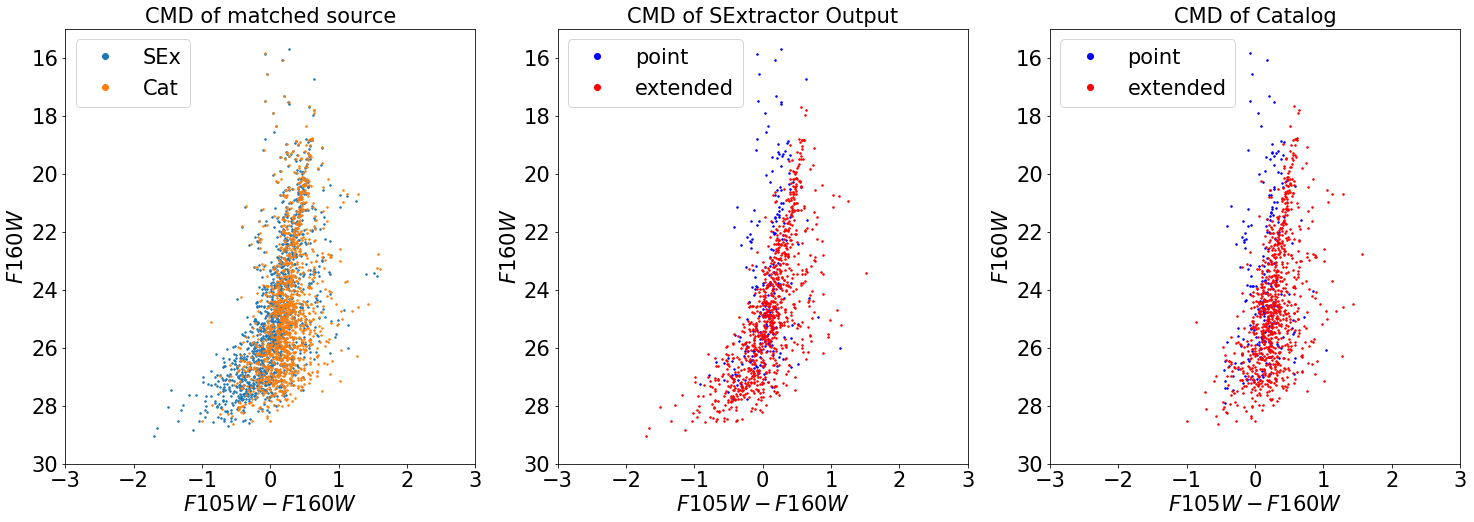

In [50]:
%matplotlib inline
fig, ax = plt.subplots(1, 3, figsize=(25,8))

ax[0].plot(matched_F105W['mag_iso']-matched_F160W['mag_iso'], matched_F160W['mag_iso'], 'o', ms = 1.5, label='SEx')
ax[0].plot(matched_Cat['f105w_mag']-matched_Cat['f160w_mag'], matched_Cat['f160w_mag'], 'o', ms = 1.5, label='Cat')
ax[0].set_title('CMD of matched source', fontsize=21)
# ax[0].plot(dat_cat['f105w_mag']-dat_cat['f160w_mag'], dat_cat['f105w_mag'], 'o', ms = 1.5)
ax[0].tick_params(axis='x', labelsize=21)
ax[0].tick_params(axis='y', labelsize=21)
ax[0].set_xlabel('$F105W - F160W$', fontsize=21)
ax[0].set_ylabel('$F160W$', fontsize=21)
ax[0].set_xlim([-3, 3])
ax[0].set_ylim([30, 15])
lgnd0 = ax[0].legend(prop={'size':21})
lgnd0.legendHandles[0]._legmarker.set_markersize(6)
lgnd0.legendHandles[1]._legmarker.set_markersize(6)


ax[1].plot(matched_F105W_point['mag_iso']-matched_F160W_point['mag_iso'], matched_F160W_point['mag_iso'], 'o', ms = 1.5, color = 'blue', label='point')
ax[1].plot(matched_F105W_extended['mag_iso']-matched_F160W_extended['mag_iso'], matched_F160W_extended['mag_iso'], 'o', ms = 1.5, color = 'red', label='extended')
ax[1].set_title('CMD of SExtractor Output', fontsize=21)
ax[1].tick_params(axis='x', labelsize=21)
ax[1].tick_params(axis='y', labelsize=21)
ax[1].set_xlabel('$F105W - F160W$', fontsize=21)
ax[1].set_ylabel('$F160W$', fontsize=21)
ax[1].set_xlim([-3, 3])
ax[1].set_ylim([30, 15])
lgnd0 = ax[1].legend(prop={'size':21})
lgnd0.legendHandles[0]._legmarker.set_markersize(6)
lgnd0.legendHandles[1]._legmarker.set_markersize(6)

ax[2].plot(matched_cat_point['f105w_mag']-matched_cat_point['f160w_mag'], matched_cat_point['f160w_mag'], 'o', ms = 1.5, color = 'blue', label='point')
ax[2].plot(matched_cat_extended['f105w_mag']-matched_cat_extended['f160w_mag'], matched_cat_extended['f160w_mag'], 'o', ms = 1.5, color = 'red', label='extended')
ax[2].set_title('CMD of Catalog', fontsize=21)
ax[2].tick_params(axis='x', labelsize=21)
ax[2].tick_params(axis='y', labelsize=21)
ax[2].set_xlabel('$F105W - F160W$', fontsize=21)
ax[2].set_ylabel('$F160W$', fontsize=21)
ax[2].set_xlim([-3, 3])
ax[2].set_ylim([30, 15])
lgnd0 = ax[2].legend(prop={'size':21})
lgnd0.legendHandles[0]._legmarker.set_markersize(6)
lgnd0.legendHandles[1]._legmarker.set_markersize(6)

이 위 그래프에서 1번째 그래프는 Matched Source를 바로 매칭해서 그린 그림 

매칭은 (2,3 번재 그래프들) Point Source 끼리, Extended Source 끼리 매칭을 진행해서 Matched Source를 나타낸 것이다.

In [51]:
print("size of catalog is {}".format(np.size(dat_cat)))
print("size of matched catalog is {}".format(np.size(matched_Cat)))
print("size of unmatched catalog is {}".format(np.size(unmatched_Cat)))
print("size of sextractor output is {}".format(np.size(dat_0)))
print("size of matched sextractor output is {}".format(np.size(matched_F105W)))
print("size of unmatched sextractor output is {}".format(np.size(unmatched_F105W)))


size of catalog is 1475
size of matched catalog is 1320
size of unmatched catalog is 176
size of sextractor output is 2483
size of matched sextractor output is 1320
size of unmatched sextractor output is 1163


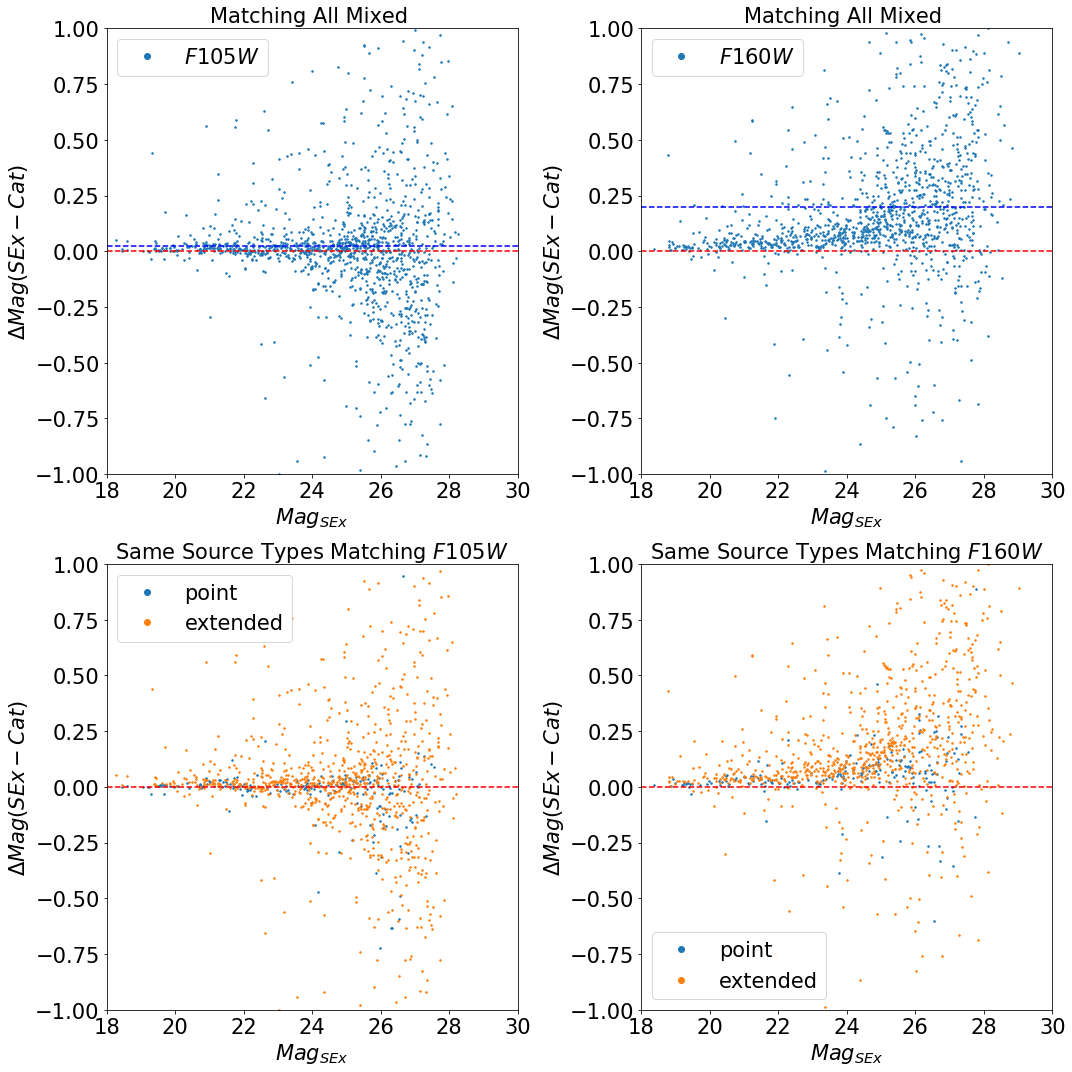

In [52]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))

ax[0,0].plot(matched_F105W['mag_iso'], matched_F105W['mag_iso']-matched_Cat['f105w_mag'], 'o', ms=1.5, label='$F105W$')
ax[0,0].set_title('Matching All Mixed ', fontsize=21)
ax[0,0].tick_params(axis='x', labelsize=21)
ax[0,0].tick_params(axis='y', labelsize=21)
ax[0,0].set_xlabel('$Mag_{SEx}$', fontsize=21)
ax[0,0].set_ylabel('$\Delta Mag (SEx - Cat)$', fontsize=21)
ax[0,0].set_xlim(18, 30)
ax[0,0].axhline(0, ls='--', color='red')
ax[0,0].set_ylim(-1, 1)
ax[0,0].axhline(stats.trim_mean(matched_F105W['mag_iso']-matched_Cat['f105w_mag'], 0.05), ls='--', color='blue')
lgnd0 = ax[0,0].legend(prop={'size':21})
lgnd0.legendHandles[0]._legmarker.set_markersize(6)


ax[0,1].plot(matched_F160W['mag_iso'], matched_F160W['mag_iso']-matched_Cat['f160w_mag'], 'o', ms=1.5, label='$F160W$')
ax[0,1].set_title('Matching All Mixed ', fontsize=21)
ax[0,1].tick_params(axis='x', labelsize=21)
ax[0,1].tick_params(axis='y', labelsize=21)
ax[0,1].set_xlabel('$Mag_{SEx}$', fontsize=21)
ax[0,1].set_ylabel('$\Delta Mag (SEx - Cat)$', fontsize=21)
ax[0,1].set_xlim(18, 30)
ax[0,1].axhline(0, ls='--', color='red')
ax[0,1].axhline(stats.trim_mean(matched_F160W['mag_iso']-matched_Cat['f160w_mag'], 0.05), ls='--', color='blue')
ax[0,1].set_ylim(-1, 1)
lgnd1 = ax[0,1].legend(prop={'size':21})
lgnd1.legendHandles[0]._legmarker.set_markersize(6)


ax[1,0].plot(matched_F105W_point['mag_iso'], matched_F105W_point['mag_iso']-matched_cat_point['f105w_mag'], 'o', ms=1.5, label='point')
ax[1,0].plot(matched_F105W_extended['mag_iso'], matched_F105W_extended['mag_iso']-matched_cat_extended['f105w_mag'], 'o', ms=1.5, label='extended')
ax[1,0].set_title('Same Source Types Matching $F105W$', fontsize=21)
ax[1,0].tick_params(axis='x', labelsize=21)
ax[1,0].tick_params(axis='y', labelsize=21)
ax[1,0].set_xlabel('$Mag_{SEx}$', fontsize=21)
ax[1,0].set_ylabel('$\Delta Mag (SEx - Cat)$', fontsize=21)
ax[1,0].set_xlim(18, 30)
ax[1,0].axhline(0, ls='--', color='red')
ax[1,0].set_ylim(-1, 1)
lgnd2 = ax[1,0].legend(prop={'size':21})
lgnd2.legendHandles[0]._legmarker.set_markersize(6)
lgnd2.legendHandles[1]._legmarker.set_markersize(6)

ax[1,1].plot(matched_F160W_point['mag_iso'], matched_F160W_point['mag_iso']-matched_cat_point['f160w_mag'], 'o', ms=1.5, label='point')
ax[1,1].plot(matched_F160W_extended['mag_iso'], matched_F160W_extended['mag_iso']-matched_cat_extended['f160w_mag'], 'o', ms=1.5, label='extended')
ax[1,1].set_title('Same Source Types Matching $F160W$', fontsize=21)
ax[1,1].tick_params(axis='x', labelsize=21)
ax[1,1].tick_params(axis='y', labelsize=21)
ax[1,1].set_xlabel('$Mag_{SEx}$', fontsize=21)
ax[1,1].set_ylabel('$\Delta Mag (SEx - Cat)$', fontsize=21)
ax[1,1].set_xlim(18, 30)
ax[1,1].axhline(0, ls='--', color='red')
ax[1,1].set_ylim(-1, 1)
lgnd3 = ax[1,1].legend(prop={'size':21})
lgnd3.legendHandles[0]._legmarker.set_markersize(6)
lgnd3.legendHandles[1]._legmarker.set_markersize(6)

plt.tight_layout()


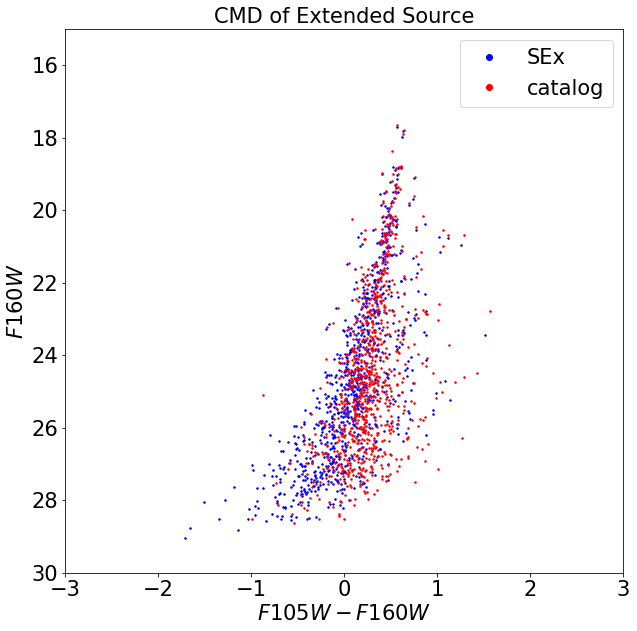

In [53]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
# ax.plot(matched_F105W_point['mag_iso']-matched_F160W_point['mag_iso'], matched_F160W_point['mag_iso'], 'o', ms = 1.5, color = 'blue')
ax.plot(matched_F105W_extended['mag_iso']-matched_F160W_extended['mag_iso'], matched_F160W_extended['mag_iso'], 'o', ms = 1.5, color = 'blue', label='SEx')
# ax.plot(matched_cat_point['f105w_mag']-matched_cat_point['f160w_mag'], matched_cat_point['f160w_mag'], 'o', ms = 1.5, color = 'red')
ax.plot(matched_cat_extended['f105w_mag']-matched_cat_extended['f160w_mag'], matched_cat_extended['f160w_mag'], 'o', ms = 1.5, color = 'red', label='catalog')
ax.set_title('CMD of Extended Source', fontsize=21)
ax.tick_params(axis='x', labelsize=21)
ax.tick_params(axis='y', labelsize=21)
ax.set_xlabel('$F105W - F160W$', fontsize=21)
ax.set_ylabel('$F160W$', fontsize=21)
ax.set_xlim([-3, 3])
ax.set_ylim([30, 15])
lgnd0 = ax.legend(prop={'size':21})
lgnd0.legendHandles[0]._legmarker.set_markersize(6)
lgnd0.legendHandles[1]._legmarker.set_markersize(6)

Matched Source의 특성들을 비교해보자. (RA/DEC, Magnitude 등등...)

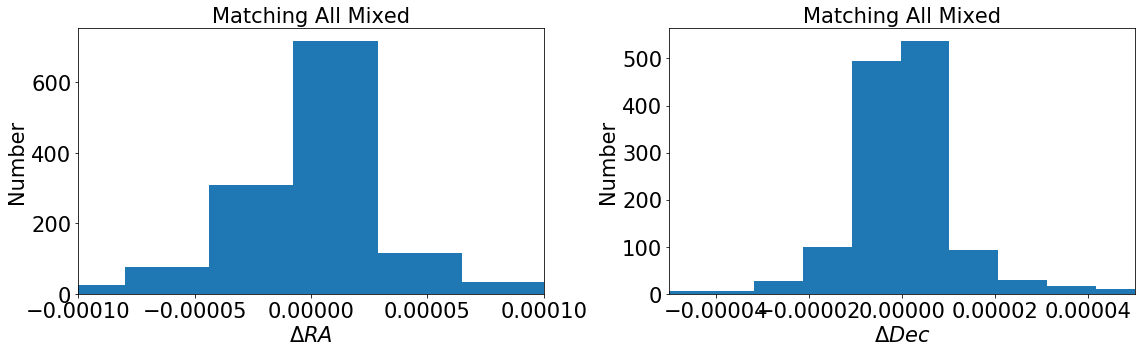

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].hist(matched_F105W['ra']-matched_Cat['RA'],bins=10)
ax[0].set_title('Matching All Mixed', fontsize=21)
ax[0].tick_params(axis='x', labelsize=21)
ax[0].tick_params(axis='y', labelsize=21)
ax[0].set_xlabel('$\Delta RA$', fontsize=21)
ax[0].set_ylabel('Number', fontsize=21)
ax[0].set_xlim(-0.0001, 0.0001)

ax[1].hist(matched_F105W['dec']-matched_Cat['Dec'],bins=10)
ax[1].set_title('Matching All Mixed', fontsize=21)
ax[1].tick_params(axis='x', labelsize=21)
ax[1].tick_params(axis='y', labelsize=21)
ax[1].set_xlabel('$\Delta Dec$', fontsize=21)
ax[1].set_ylabel('Number', fontsize=21)
ax[1].set_xlim(-0.00005, 0.00005)

plt.tight_layout()

## 3) UnMatched Source

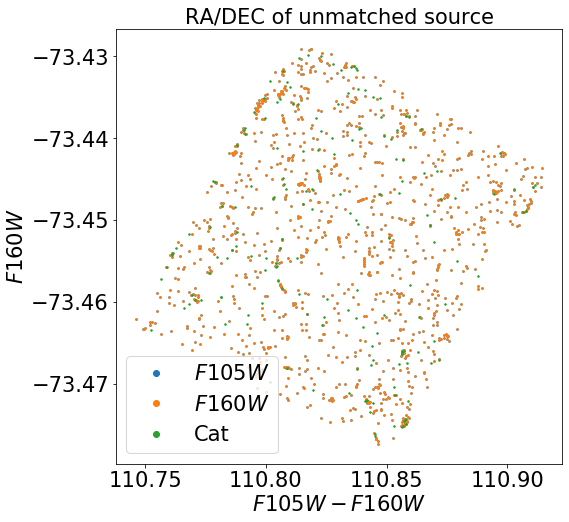

In [55]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(8,8))

ax.plot(unmatched_F105W['ra'],unmatched_F105W['dec'], 'o', ms = 1.5, label='$F105W$')
ax.plot(unmatched_F160W['ra'],unmatched_F160W['dec'], 'o', ms = 1.5, label='$F160W$')
ax.plot(unmatched_Cat['RA'], unmatched_Cat['Dec'], 'o', ms = 1.5, label='Cat')
ax.set_title('RA/DEC of unmatched source', fontsize=21)
ax.tick_params(axis='x', labelsize=21)
ax.tick_params(axis='y', labelsize=21)
ax.set_xlabel('$F105W - F160W$', fontsize=21)
ax.set_ylabel('$F160W$', fontsize=21)
lgnd0 = ax.legend(prop={'size':21})
lgnd0.legendHandles[0]._legmarker.set_markersize(6)
lgnd0.legendHandles[1]._legmarker.set_markersize(6)
lgnd0.legendHandles[2]._legmarker.set_markersize(6)

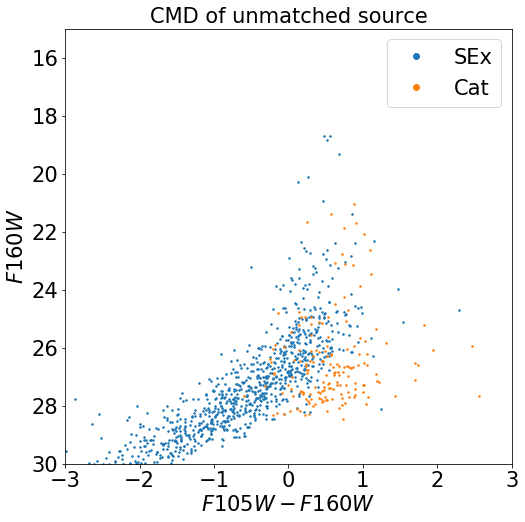

In [56]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(8,8))

ax.plot(unmatched_F105W['mag_iso']-unmatched_F160W['mag_iso'], unmatched_F160W['mag_iso'], 'o', ms = 1.5, label='SEx')
ax.plot(unmatched_Cat['f105w_mag']-unmatched_Cat['f160w_mag'], unmatched_Cat['f160w_mag'], 'o', ms = 1.5, label='Cat')
ax.set_title('CMD of unmatched source', fontsize=21)
# ax.plot(dat_cat['f105w_mag']-dat_cat['f160w_mag'], dat_cat['f105w_mag'], 'o', ms = 1.5)
ax.tick_params(axis='x', labelsize=21)
ax.tick_params(axis='y', labelsize=21)
ax.set_xlabel('$F105W - F160W$', fontsize=21)
ax.set_ylabel('$F160W$', fontsize=21)
ax.set_xlim([-3, 3])
ax.set_ylim([30, 15])
lgnd0 = ax.legend(prop={'size':21})
lgnd0.legendHandles[0]._legmarker.set_markersize(6)
lgnd0.legendHandles[1]._legmarker.set_markersize(6)

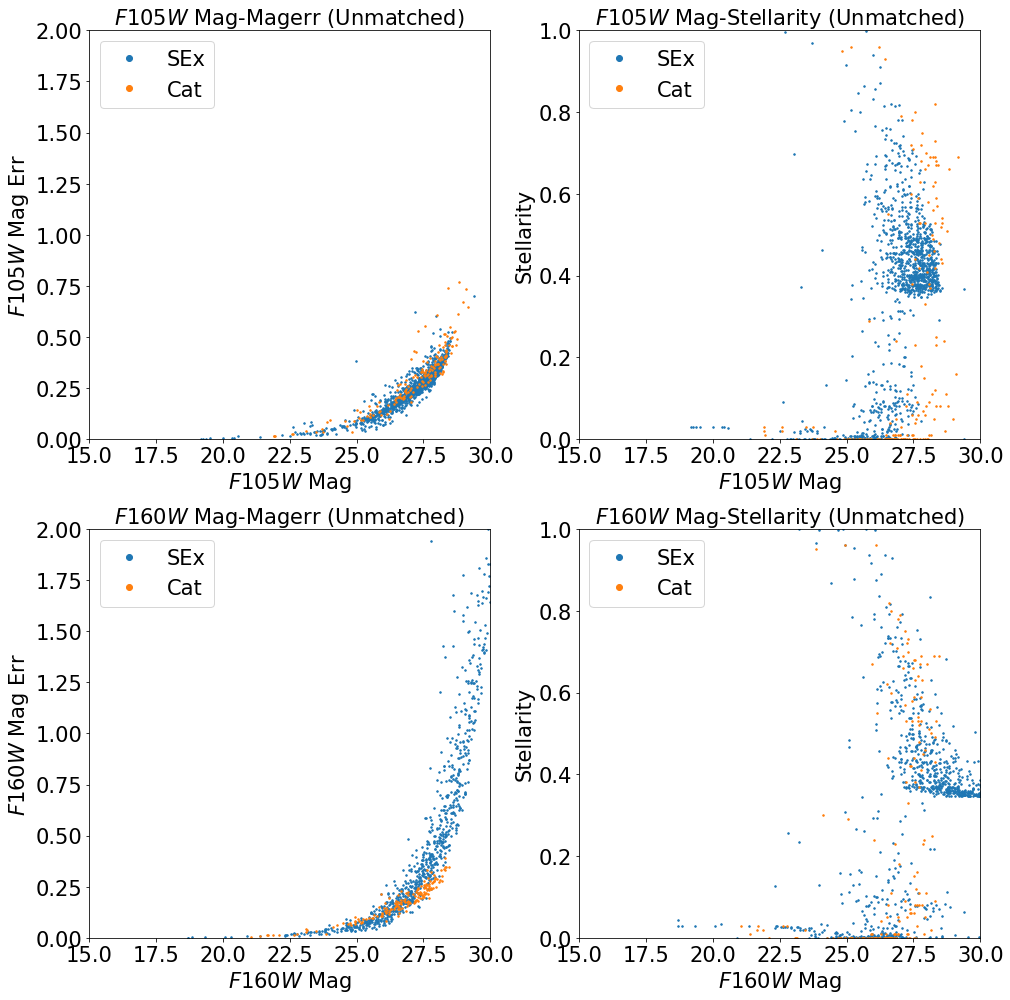

In [57]:
fig, ax = plt.subplots(2, 2, figsize=(14, 14))
ax[0,0].plot(unmatched_F105W['mag_iso'], unmatched_F105W['merr_iso'], 'o', ms = 1.5, label = 'SEx')
ax[0,0].plot(unmatched_Cat['f105w_mag'], unmatched_Cat['f105w_magerr'], 'o', ms = 1.5, label='Cat')
ax[0,0].set_title('$F105W$ Mag-Magerr (Unmatched)', fontsize=21)
ax[0,0].tick_params(axis='x', labelsize=21)
ax[0,0].tick_params(axis='y', labelsize=21)
ax[0,0].set_xlabel('$F105W$ Mag', fontsize=21)
ax[0,0].set_ylabel('$F105W$ Mag Err', fontsize=21)
ax[0,0].set_xlim([15, 30])
ax[0,0].set_ylim([0, 2])
lgnd0 = ax[0,0].legend(prop={'size':21})
lgnd0.legendHandles[0]._legmarker.set_markersize(6)
lgnd0.legendHandles[1]._legmarker.set_markersize(6)

ax[0,1].plot(unmatched_F105W['mag_iso'], unmatched_F105W['cl'], 'o', ms = 1.5, label = 'SEx')
ax[0,1].plot(unmatched_Cat['f105w_mag'], unmatched_Cat['stel'], 'o', ms = 1.5, label='Cat')
ax[0,1].set_title('$F105W$ Mag-Stellarity (Unmatched)', fontsize=21)
ax[0,1].tick_params(axis='x', labelsize=21)
ax[0,1].tick_params(axis='y', labelsize=21)
ax[0,1].set_xlabel('$F105W$ Mag', fontsize=21)
ax[0,1].set_ylabel('Stellarity', fontsize=21)
ax[0,1].set_xlim([15, 30])
ax[0,1].set_ylim([0, 1])
lgnd1 = ax[0,1].legend(prop={'size':21})
lgnd1.legendHandles[0]._legmarker.set_markersize(6)
lgnd1.legendHandles[1]._legmarker.set_markersize(6)

ax[1,0].plot(unmatched_F160W['mag_iso'], unmatched_F160W['merr_iso'], 'o', ms = 1.5, label = 'SEx')
ax[1,0].plot(unmatched_Cat['f160w_mag'], unmatched_Cat['f160w_magerr'], 'o', ms = 1.5, label='Cat')
ax[1,0].set_title('$F160W$ Mag-Magerr (Unmatched)', fontsize=21)
ax[1,0].tick_params(axis='x', labelsize=21)
ax[1,0].tick_params(axis='y', labelsize=21)
ax[1,0].set_xlabel('$F160W$ Mag', fontsize=21)
ax[1,0].set_ylabel('$F160W$ Mag Err', fontsize=21)
ax[1,0].set_xlim([15, 30])
ax[1,0].set_ylim([0, 2])
lgnd2 = ax[1,0].legend(prop={'size':21})
lgnd2.legendHandles[0]._legmarker.set_markersize(6)
lgnd2.legendHandles[1]._legmarker.set_markersize(6)

ax[1,1].plot(unmatched_F160W['mag_iso'], unmatched_F160W['cl'], 'o', ms = 1.5, label = 'SEx')
ax[1,1].plot(unmatched_Cat['f160w_mag'], unmatched_Cat['stel'], 'o', ms = 1.5, label='Cat')
ax[1,1].set_title('$F160W$ Mag-Stellarity (Unmatched)', fontsize=21)
ax[1,1].tick_params(axis='x', labelsize=21)
ax[1,1].tick_params(axis='y', labelsize=21)
ax[1,1].set_xlabel('$F160W$ Mag', fontsize=21)
ax[1,1].set_ylabel('Stellarity', fontsize=21)
ax[1,1].set_xlim([15, 30])
ax[1,1].set_ylim([0, 1])
lgnd2 = ax[1,1].legend(prop={'size':21})
lgnd2.legendHandles[0]._legmarker.set_markersize(6)
lgnd2.legendHandles[1]._legmarker.set_markersize(6)


plt.tight_layout()


In [58]:
# test.reg 만드는 코드 

f = open('test1.reg', 'w')

src1 = [unmatched_F105W['x'], unmatched_F105W['y']]     
src1 = np.transpose(src1)
src1 = pd.DataFrame(src1, columns=['x', 'y'])
src2 = [unmatched_F160W['x'], unmatched_F160W['y']]     
src2 = np.transpose(src2)
src2 = pd.DataFrame(src2, columns=['x', 'y'])

for i in np.arange(len(src1)):
    f.write('image;circle(%.2f, %.2f, 20) \n' %(src1['x'][i], src1['y'][i]))
    # 이미지에서 source의 x, y 좌표를 중심으로 한 20 pixel 반경의 원을 display하여 보여주는 region file 쓰기

for i in np.arange(len(src2)):
    f.write('image;circle(%.2f, %.2f, 20) \n' %(src2['x'][i], src2['y'][i]))
    
f.close()

### 디스플레이 방법: DS9 - Region - Load regions - 'test.reg' 열기



# 2. F105W-F160W (refimg changed to F160W )   (F160W-F105W 라고 표기) 

In [59]:
%matplotlib inline

In [60]:
dat_cat = np.genfromtxt('../1st_TASK_Relics_SMACS/catalog/hlsp_relics_hst_wfc3ir_smacs0723-73_multi_v1_cat.txt', dtype=None, encoding='ascii', names=colnames_cat)
dat_0 = np.genfromtxt( '/data/jip/1st_TASK_Relics_SMACS/Analysis-Result/60mas/F160W-F105W/Threshold_Low/F105W.cat', dtype=None, encoding='ascii', names=colnames)
dat_1 = np.genfromtxt('/data/jip/1st_TASK_Relics_SMACS/Analysis-Result/60mas/F160W-F105W/Threshold_Low/F160W.cat', dtype=None, encoding='ascii', names=colnames)

# dat_0 = np.genfromtxt( '/data/jip/1st_TASK_Relics_SMACS/F105W.cat', dtype=None, encoding='ascii', names=colnames)
# dat_1 = np.genfromtxt( '/data/jip/1st_TASK_Relics_SMACS/F160W.cat', dtype=None, encoding='ascii', names=colnames)


band = ["F105W", "F160W"]
band_catread = ["f105w", "f160w"]

# dat_0, dat_1, dat_cat = satlim(dat_0), satlim(dat_1), satlim(dat_cat)
dat_0 = galextcor(dat_0, "F105W")
dat_1 = galextcor(dat_1, "F160W")

#======================= Data에서 바로 Matching 

matched_F105W = matchingsexcat(dat_0, dat_cat).matchedsex(dat_0)
matched_F160W = matchingsexcat(dat_1, dat_cat).matchedsex(dat_1)
matched_Cat = matchingsexcat(dat_0, dat_cat).matchedcat(dat_cat)

#======================== Raw Data에서 point/Extended source 나눠서 라벨링

pointsource_sex = dat_0['cl']>0.6
pointsource_cat = dat_cat['stel']>0.6 #matached_Cat
extendedsource_sex = dat_0['cl']<0.6
extendedsource_cat = dat_cat['stel']<0.6 #matached_Cat

dat_0_pointsource = dat_0[pointsource_sex]
dat_0_extendedsource = dat_0[extendedsource_sex]
dat_1_pointsource = dat_1[pointsource_sex]
dat_1_extendedsource = dat_1[extendedsource_sex]

dat_cat_pointsource = dat_cat[pointsource_cat] #matached_Cat
dat_cat_extendedsource = dat_cat[extendedsource_cat] #matched_cat


#============= point / extended source 나눠서 matching ===============
matched_F105W_point = matchingsexcat(dat_0_pointsource, dat_cat_pointsource).matchedsex(dat_0_pointsource)
matched_F105W_extended = matchingsexcat(dat_0_extendedsource, dat_cat_extendedsource).matchedsex(dat_0_extendedsource)
matched_F160W_point = matchingsexcat(dat_1_pointsource, dat_cat_pointsource).matchedsex(dat_1_pointsource)
matched_F160W_extended = matchingsexcat(dat_1_extendedsource, dat_cat_extendedsource).matchedsex(dat_1_extendedsource)

matched_cat_point = matchingsexcat(dat_0_pointsource, dat_cat_pointsource).matchedcat(dat_cat_pointsource)
matched_cat_extended = matchingsexcat(dat_0_extendedsource, dat_cat_extendedsource).matchedcat(dat_cat_extendedsource)


#=============== Unmatched Output / Catalog 분리
F105Wmatch = [] 
for i in range(np.size(dat_0)):
    if dat_0[i] not in matched_F105W:
        F105Wmatch.append(i)

unmatched_F105W = dat_0[F105Wmatch]

F160Wmatch = [] 
for i in range(np.size(dat_1)):
    if dat_1[i] not in matched_F160W:
        F160Wmatch.append(i)

unmatched_F160W = dat_1[F160Wmatch]

catmatch = [] 
for i in range(np.size(dat_cat)):
    if dat_cat[i] not in matched_Cat:
        catmatch.append(i)

unmatched_Cat = dat_cat[catmatch]


## 1) Raw Data

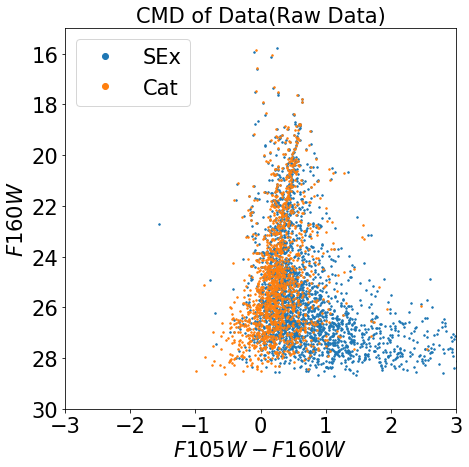

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.plot(dat_0['mag_iso']-dat_1['mag_iso'], dat_1['mag_iso'], 'o', ms = 1.5, label = 'SEx')
ax.plot(dat_cat['f105w_mag']-dat_cat['f160w_mag'], dat_cat['f160w_mag'], 'o', ms = 1.5, label='Cat')
ax.set_title('CMD of Data(Raw Data)', fontsize=21)
ax.tick_params(axis='x', labelsize=21)
ax.tick_params(axis='y', labelsize=21)
ax.set_xlabel('$F105W - F160W$', fontsize=21)
ax.set_ylabel('$F160W$', fontsize=21)
ax.set_xlim([-3, 3])
ax.set_ylim([30, 15])
lgnd0 = ax.legend(prop={'size':21})
lgnd0.legendHandles[0]._legmarker.set_markersize(6)
lgnd0.legendHandles[1]._legmarker.set_markersize(6)

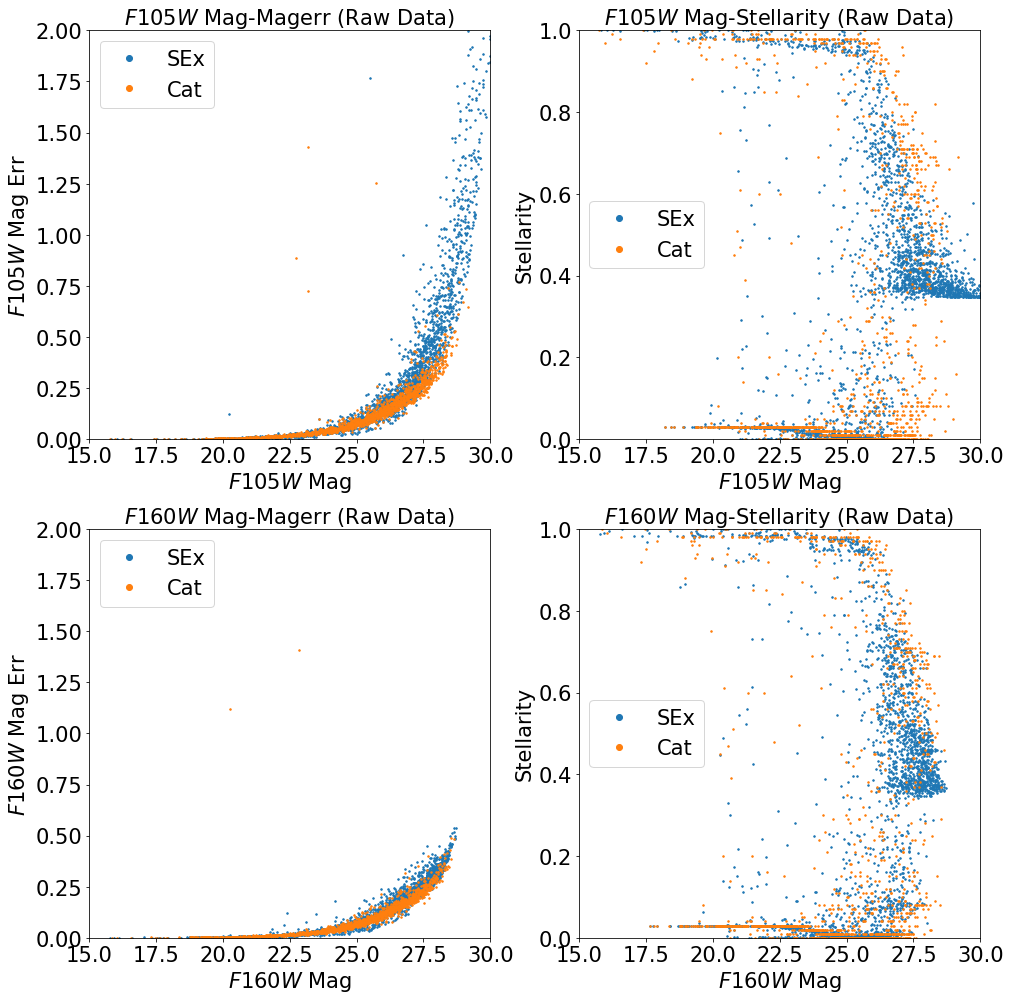

In [62]:
fig, ax = plt.subplots(2, 2, figsize=(14, 14))
ax[0,0].plot(dat_0['mag_iso'], dat_0['merr_iso'], 'o', ms = 1.5, label = 'SEx')
ax[0,0].plot(dat_cat['f105w_mag'], dat_cat['f105w_magerr'], 'o', ms = 1.5, label='Cat')
ax[0,0].set_title('$F105W$ Mag-Magerr (Raw Data)', fontsize=21)
ax[0,0].tick_params(axis='x', labelsize=21)
ax[0,0].tick_params(axis='y', labelsize=21)
ax[0,0].set_xlabel('$F105W$ Mag', fontsize=21)
ax[0,0].set_ylabel('$F105W$ Mag Err', fontsize=21)
ax[0,0].set_xlim([15, 30])
ax[0,0].set_ylim([0, 2])
lgnd0 = ax[0,0].legend(prop={'size':21})
lgnd0.legendHandles[0]._legmarker.set_markersize(6)
lgnd0.legendHandles[1]._legmarker.set_markersize(6)

ax[0,1].plot(dat_0['mag_iso'], dat_0['cl'], 'o', ms = 1.5, label = 'SEx')
ax[0,1].plot(dat_cat['f105w_mag'], dat_cat['stel'], 'o', ms = 1.5, label='Cat')
ax[0,1].set_title('$F105W$ Mag-Stellarity (Raw Data)', fontsize=21)
ax[0,1].tick_params(axis='x', labelsize=21)
ax[0,1].tick_params(axis='y', labelsize=21)
ax[0,1].set_xlabel('$F105W$ Mag', fontsize=21)
ax[0,1].set_ylabel('Stellarity', fontsize=21)
ax[0,1].set_xlim([15, 30])
ax[0,1].set_ylim([0, 1])
lgnd1 = ax[0,1].legend(prop={'size':21})
lgnd1.legendHandles[0]._legmarker.set_markersize(6)
lgnd1.legendHandles[1]._legmarker.set_markersize(6)

ax[1,0].plot(dat_1['mag_iso'], dat_1['merr_iso'], 'o', ms = 1.5, label = 'SEx')
ax[1,0].plot(dat_cat['f160w_mag'], dat_cat['f160w_magerr'], 'o', ms = 1.5, label='Cat')
ax[1,0].set_title('$F160W$ Mag-Magerr (Raw Data)', fontsize=21)
ax[1,0].tick_params(axis='x', labelsize=21)
ax[1,0].tick_params(axis='y', labelsize=21)
ax[1,0].set_xlabel('$F160W$ Mag', fontsize=21)
ax[1,0].set_ylabel('$F160W$ Mag Err', fontsize=21)
ax[1,0].set_xlim([15, 30])
ax[1,0].set_ylim([0, 2])
lgnd2 = ax[1,0].legend(prop={'size':21})
lgnd2.legendHandles[0]._legmarker.set_markersize(6)
lgnd2.legendHandles[1]._legmarker.set_markersize(6)

ax[1,1].plot(dat_1['mag_iso'], dat_1['cl'], 'o', ms = 1.5, label = 'SEx')
ax[1,1].plot(dat_cat['f160w_mag'], dat_cat['stel'], 'o', ms = 1.5, label='Cat')
ax[1,1].set_title('$F160W$ Mag-Stellarity (Raw Data)', fontsize=21)
ax[1,1].tick_params(axis='x', labelsize=21)
ax[1,1].tick_params(axis='y', labelsize=21)
ax[1,1].set_xlabel('$F160W$ Mag', fontsize=21)
ax[1,1].set_ylabel('Stellarity', fontsize=21)
ax[1,1].set_xlim([15, 30])
ax[1,1].set_ylim([0, 1])
lgnd2 = ax[1,1].legend(prop={'size':21})
lgnd2.legendHandles[0]._legmarker.set_markersize(6)
lgnd2.legendHandles[1]._legmarker.set_markersize(6)


plt.tight_layout()


## 2) Matched Source

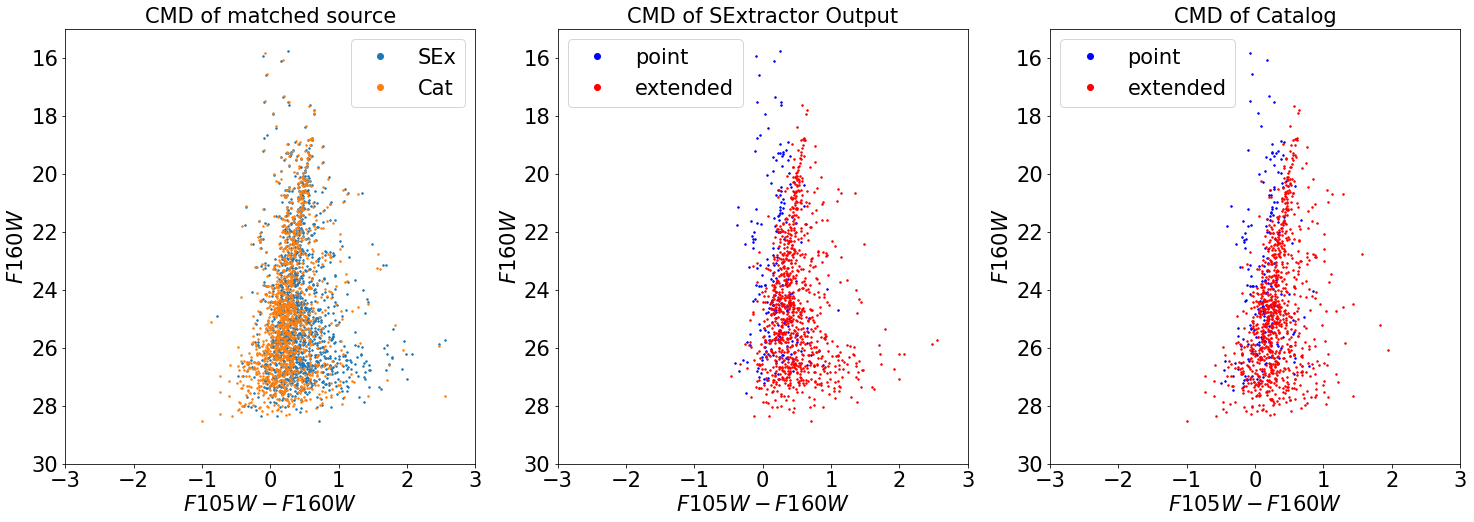

In [63]:
%matplotlib inline
fig, ax = plt.subplots(1, 3, figsize=(25,8))

ax[0].plot(matched_F105W['mag_iso']-matched_F160W['mag_iso'], matched_F160W['mag_iso'], 'o', ms = 1.5, label='SEx')
ax[0].plot(matched_Cat['f105w_mag']-matched_Cat['f160w_mag'], matched_Cat['f160w_mag'], 'o', ms = 1.5, label='Cat')
ax[0].set_title('CMD of matched source', fontsize=21)
# ax[0].plot(dat_cat['f105w_mag']-dat_cat['f160w_mag'], dat_cat['f105w_mag'], 'o', ms = 1.5)
ax[0].tick_params(axis='x', labelsize=21)
ax[0].tick_params(axis='y', labelsize=21)
ax[0].set_xlabel('$F105W - F160W$', fontsize=21)
ax[0].set_ylabel('$F160W$', fontsize=21)
ax[0].set_xlim([-3, 3])
ax[0].set_ylim([30, 15])
lgnd0 = ax[0].legend(prop={'size':21})
lgnd0.legendHandles[0]._legmarker.set_markersize(6)
lgnd0.legendHandles[1]._legmarker.set_markersize(6)


ax[1].plot(matched_F105W_point['mag_iso']-matched_F160W_point['mag_iso'], matched_F160W_point['mag_iso'], 'o', ms = 1.5, color = 'blue', label='point')
ax[1].plot(matched_F105W_extended['mag_iso']-matched_F160W_extended['mag_iso'], matched_F160W_extended['mag_iso'], 'o', ms = 1.5, color = 'red', label='extended')
ax[1].set_title('CMD of SExtractor Output', fontsize=21)
ax[1].tick_params(axis='x', labelsize=21)
ax[1].tick_params(axis='y', labelsize=21)
ax[1].set_xlabel('$F105W - F160W$', fontsize=21)
ax[1].set_ylabel('$F160W$', fontsize=21)
ax[1].set_xlim([-3, 3])
ax[1].set_ylim([30, 15])
lgnd0 = ax[1].legend(prop={'size':21})
lgnd0.legendHandles[0]._legmarker.set_markersize(6)
lgnd0.legendHandles[1]._legmarker.set_markersize(6)

ax[2].plot(matched_cat_point['f105w_mag']-matched_cat_point['f160w_mag'], matched_cat_point['f160w_mag'], 'o', ms = 1.5, color = 'blue', label='point')
ax[2].plot(matched_cat_extended['f105w_mag']-matched_cat_extended['f160w_mag'], matched_cat_extended['f160w_mag'], 'o', ms = 1.5, color = 'red', label='extended')
ax[2].set_title('CMD of Catalog', fontsize=21)
ax[2].tick_params(axis='x', labelsize=21)
ax[2].tick_params(axis='y', labelsize=21)
ax[2].set_xlabel('$F105W - F160W$', fontsize=21)
ax[2].set_ylabel('$F160W$', fontsize=21)
ax[2].set_xlim([-3, 3])
ax[2].set_ylim([30, 15])
lgnd0 = ax[2].legend(prop={'size':21})
lgnd0.legendHandles[0]._legmarker.set_markersize(6)
lgnd0.legendHandles[1]._legmarker.set_markersize(6)

이 위 그래프에서 1번째 그래프는 Matched Source를 바로 매칭해서 그린 그림 

매칭은 (2,3 번재 그래프들) Point Source 끼리, Extended Source 끼리 매칭을 진행해서 Matched Source를 나타낸 것이다.

In [64]:
print("size of catalog is {}".format(np.size(dat_cat)))
print("size of matched catalog is {}".format(np.size(matched_Cat)))
print("size of unmatched catalog is {}".format(np.size(unmatched_Cat)))
print("size of sextractor output is {}".format(np.size(dat_0)))
print("size of matched sextractor output is {}".format(np.size(matched_F105W)))
print("size of unmatched sextractor output is {}".format(np.size(unmatched_F105W)))


size of catalog is 1475
size of matched catalog is 1385
size of unmatched catalog is 110
size of sextractor output is 2647
size of matched sextractor output is 1385
size of unmatched sextractor output is 1262


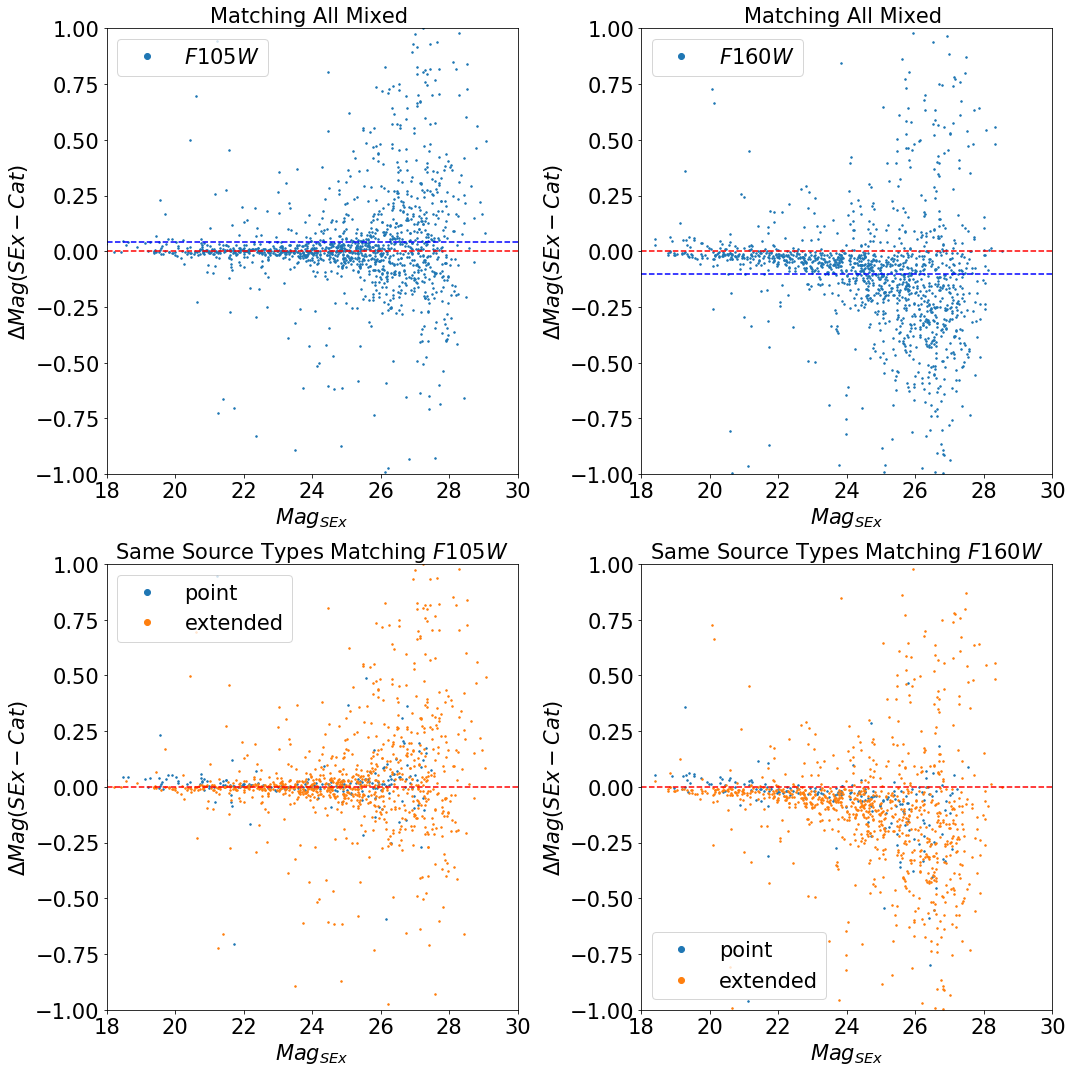

In [65]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))

ax[0,0].plot(matched_F105W['mag_iso'], matched_F105W['mag_iso']-matched_Cat['f105w_mag'], 'o', ms=1.5, label='$F105W$')
ax[0,0].set_title('Matching All Mixed ', fontsize=21)
ax[0,0].tick_params(axis='x', labelsize=21)
ax[0,0].tick_params(axis='y', labelsize=21)
ax[0,0].set_xlabel('$Mag_{SEx}$', fontsize=21)
ax[0,0].set_ylabel('$\Delta Mag (SEx - Cat)$', fontsize=21)
ax[0,0].set_xlim(18, 30)
ax[0,0].axhline(0, ls='--', color='red')
ax[0,0].set_ylim(-1, 1)
ax[0,0].axhline(stats.trim_mean(matched_F105W['mag_iso']-matched_Cat['f105w_mag'], 0.05), ls='--', color='blue')
lgnd0 = ax[0,0].legend(prop={'size':21})
lgnd0.legendHandles[0]._legmarker.set_markersize(6)


ax[0,1].plot(matched_F160W['mag_iso'], matched_F160W['mag_iso']-matched_Cat['f160w_mag'], 'o', ms=1.5, label='$F160W$')
ax[0,1].set_title('Matching All Mixed ', fontsize=21)
ax[0,1].tick_params(axis='x', labelsize=21)
ax[0,1].tick_params(axis='y', labelsize=21)
ax[0,1].set_xlabel('$Mag_{SEx}$', fontsize=21)
ax[0,1].set_ylabel('$\Delta Mag (SEx - Cat)$', fontsize=21)
ax[0,1].set_xlim(18, 30)
ax[0,1].axhline(0, ls='--', color='red')
ax[0,1].axhline(stats.trim_mean(matched_F160W['mag_iso']-matched_Cat['f160w_mag'], 0.05), ls='--', color='blue')
ax[0,1].set_ylim(-1, 1)
lgnd1 = ax[0,1].legend(prop={'size':21})
lgnd1.legendHandles[0]._legmarker.set_markersize(6)


ax[1,0].plot(matched_F105W_point['mag_iso'], matched_F105W_point['mag_iso']-matched_cat_point['f105w_mag'], 'o', ms=1.5, label='point')
ax[1,0].plot(matched_F105W_extended['mag_iso'], matched_F105W_extended['mag_iso']-matched_cat_extended['f105w_mag'], 'o', ms=1.5, label='extended')
ax[1,0].set_title('Same Source Types Matching $F105W$', fontsize=21)
ax[1,0].tick_params(axis='x', labelsize=21)
ax[1,0].tick_params(axis='y', labelsize=21)
ax[1,0].set_xlabel('$Mag_{SEx}$', fontsize=21)
ax[1,0].set_ylabel('$\Delta Mag (SEx - Cat)$', fontsize=21)
ax[1,0].set_xlim(18, 30)
ax[1,0].axhline(0, ls='--', color='red')
ax[1,0].set_ylim(-1, 1)
lgnd2 = ax[1,0].legend(prop={'size':21})
lgnd2.legendHandles[0]._legmarker.set_markersize(6)
lgnd2.legendHandles[1]._legmarker.set_markersize(6)

ax[1,1].plot(matched_F160W_point['mag_iso'], matched_F160W_point['mag_iso']-matched_cat_point['f160w_mag'], 'o', ms=1.5, label='point')
ax[1,1].plot(matched_F160W_extended['mag_iso'], matched_F160W_extended['mag_iso']-matched_cat_extended['f160w_mag'], 'o', ms=1.5, label='extended')
ax[1,1].set_title('Same Source Types Matching $F160W$', fontsize=21)
ax[1,1].tick_params(axis='x', labelsize=21)
ax[1,1].tick_params(axis='y', labelsize=21)
ax[1,1].set_xlabel('$Mag_{SEx}$', fontsize=21)
ax[1,1].set_ylabel('$\Delta Mag (SEx - Cat)$', fontsize=21)
ax[1,1].set_xlim(18, 30)
ax[1,1].axhline(0, ls='--', color='red')
ax[1,1].set_ylim(-1, 1)
lgnd3 = ax[1,1].legend(prop={'size':21})
lgnd3.legendHandles[0]._legmarker.set_markersize(6)
lgnd3.legendHandles[1]._legmarker.set_markersize(6)

plt.tight_layout()


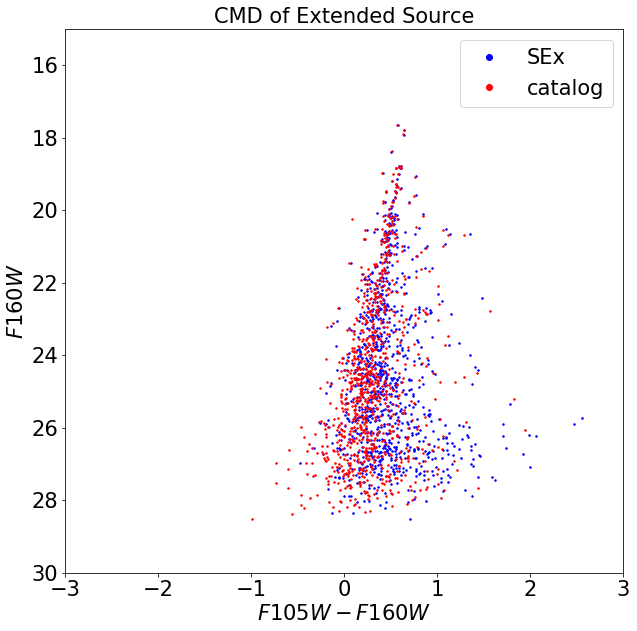

In [66]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
# ax.plot(matched_F105W_point['mag_iso']-matched_F160W_point['mag_iso'], matched_F160W_point['mag_iso'], 'o', ms = 1.5, color = 'blue')
ax.plot(matched_F105W_extended['mag_iso']-matched_F160W_extended['mag_iso'], matched_F160W_extended['mag_iso'], 'o', ms = 1.5, color = 'blue', label='SEx')
# ax.plot(matched_cat_point['f105w_mag']-matched_cat_point['f160w_mag'], matched_cat_point['f160w_mag'], 'o', ms = 1.5, color = 'red')
ax.plot(matched_cat_extended['f105w_mag']-matched_cat_extended['f160w_mag'], matched_cat_extended['f160w_mag'], 'o', ms = 1.5, color = 'red', label='catalog')
ax.set_title('CMD of Extended Source', fontsize=21)
ax.tick_params(axis='x', labelsize=21)
ax.tick_params(axis='y', labelsize=21)
ax.set_xlabel('$F105W - F160W$', fontsize=21)
ax.set_ylabel('$F160W$', fontsize=21)
ax.set_xlim([-3, 3])
ax.set_ylim([30, 15])
lgnd0 = ax.legend(prop={'size':21})
lgnd0.legendHandles[0]._legmarker.set_markersize(6)
lgnd0.legendHandles[1]._legmarker.set_markersize(6)

Matched Source의 특성들을 비교해보자. (RA/DEC, Magnitude 등등...)

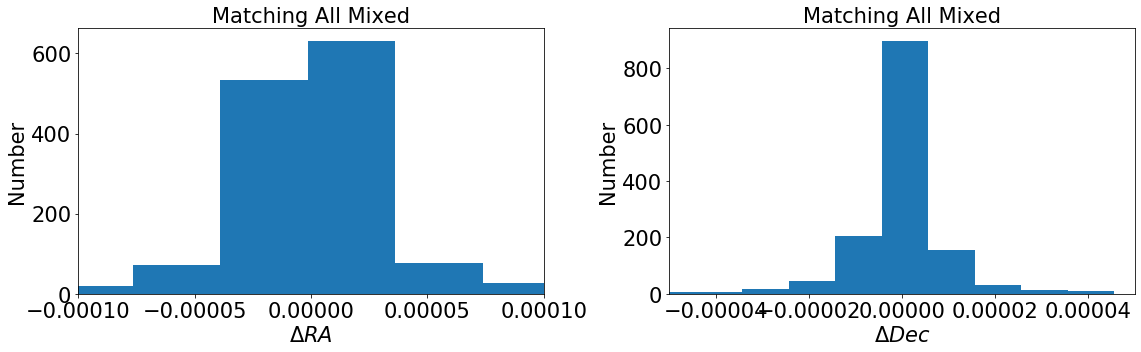

In [67]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].hist(matched_F105W['ra']-matched_Cat['RA'],bins=10)
ax[0].set_title('Matching All Mixed', fontsize=21)
ax[0].tick_params(axis='x', labelsize=21)
ax[0].tick_params(axis='y', labelsize=21)
ax[0].set_xlabel('$\Delta RA$', fontsize=21)
ax[0].set_ylabel('Number', fontsize=21)
ax[0].set_xlim(-0.0001, 0.0001)

ax[1].hist(matched_F105W['dec']-matched_Cat['Dec'],bins=10)
ax[1].set_title('Matching All Mixed', fontsize=21)
ax[1].tick_params(axis='x', labelsize=21)
ax[1].tick_params(axis='y', labelsize=21)
ax[1].set_xlabel('$\Delta Dec$', fontsize=21)
ax[1].set_ylabel('Number', fontsize=21)
ax[1].set_xlim(-0.00005, 0.00005)

plt.tight_layout()

## 3) UnMatched Source

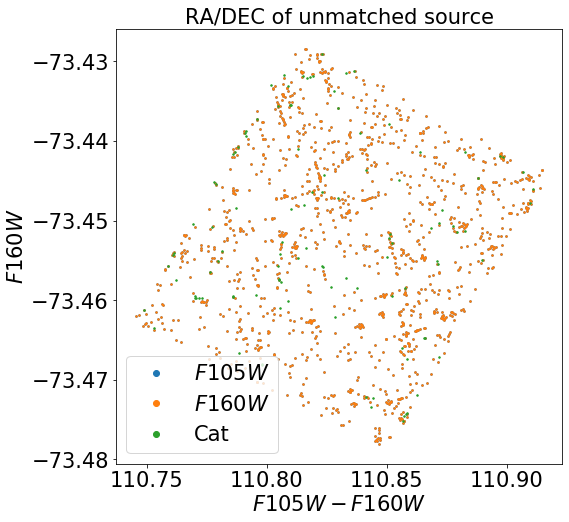

In [68]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(8,8))

ax.plot(unmatched_F105W['ra'],unmatched_F105W['dec'], 'o', ms = 1.5, label='$F105W$')
ax.plot(unmatched_F160W['ra'],unmatched_F160W['dec'], 'o', ms = 1.5, label='$F160W$')
ax.plot(unmatched_Cat['RA'], unmatched_Cat['Dec'], 'o', ms = 1.5, label='Cat')
ax.set_title('RA/DEC of unmatched source', fontsize=21)
ax.tick_params(axis='x', labelsize=21)
ax.tick_params(axis='y', labelsize=21)
ax.set_xlabel('$F105W - F160W$', fontsize=21)
ax.set_ylabel('$F160W$', fontsize=21)
lgnd0 = ax.legend(prop={'size':21})
lgnd0.legendHandles[0]._legmarker.set_markersize(6)
lgnd0.legendHandles[1]._legmarker.set_markersize(6)
lgnd0.legendHandles[2]._legmarker.set_markersize(6)

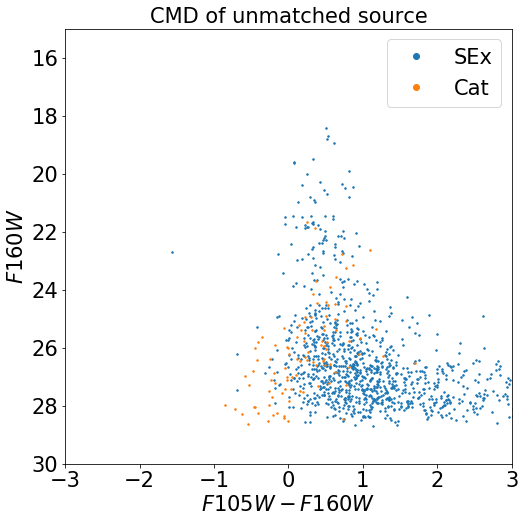

In [69]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(8,8))

ax.plot(unmatched_F105W['mag_iso']-unmatched_F160W['mag_iso'], unmatched_F160W['mag_iso'], 'o', ms = 1.5, label='SEx')
ax.plot(unmatched_Cat['f105w_mag']-unmatched_Cat['f160w_mag'], unmatched_Cat['f160w_mag'], 'o', ms = 1.5, label='Cat')
ax.set_title('CMD of unmatched source', fontsize=21)
# ax.plot(dat_cat['f105w_mag']-dat_cat['f160w_mag'], dat_cat['f105w_mag'], 'o', ms = 1.5)
ax.tick_params(axis='x', labelsize=21)
ax.tick_params(axis='y', labelsize=21)
ax.set_xlabel('$F105W - F160W$', fontsize=21)
ax.set_ylabel('$F160W$', fontsize=21)
ax.set_xlim([-3, 3])
ax.set_ylim([30, 15])
lgnd0 = ax.legend(prop={'size':21})
lgnd0.legendHandles[0]._legmarker.set_markersize(6)
lgnd0.legendHandles[1]._legmarker.set_markersize(6)

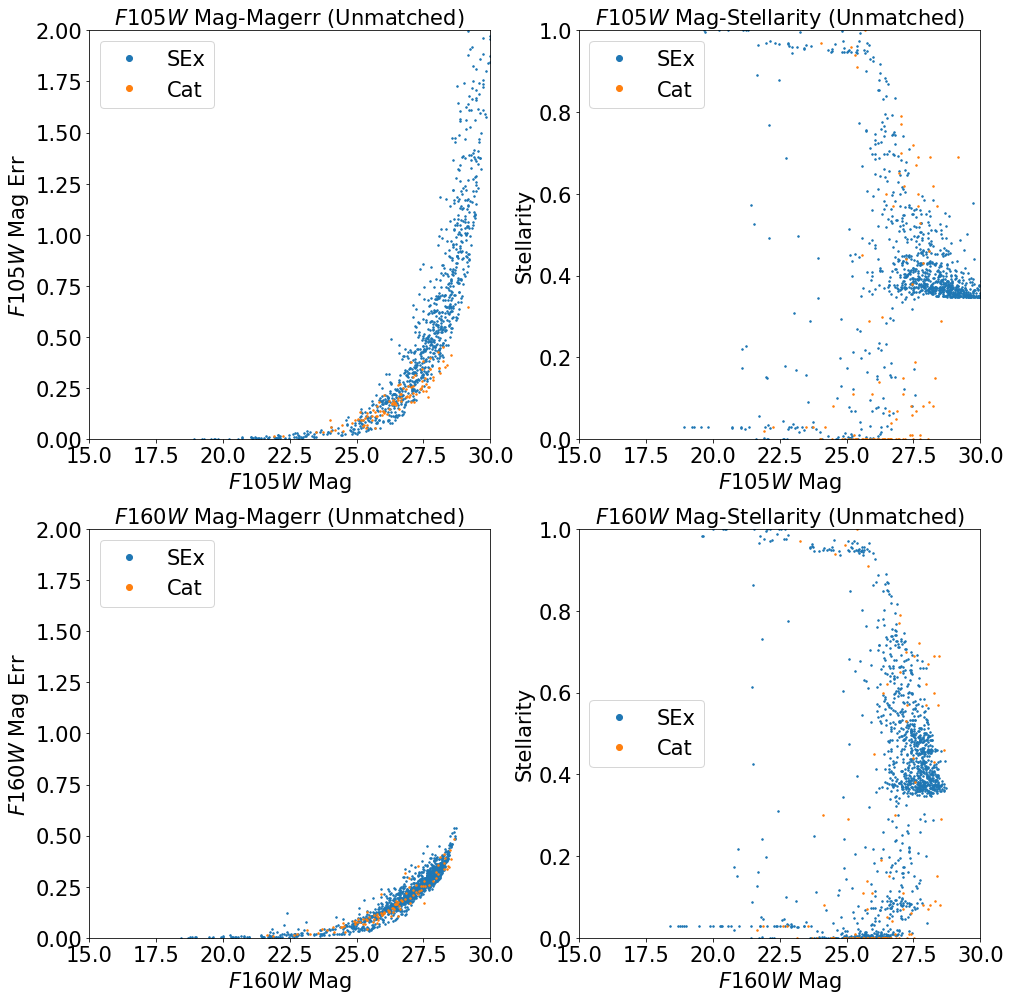

In [70]:
fig, ax = plt.subplots(2, 2, figsize=(14, 14))
ax[0,0].plot(unmatched_F105W['mag_iso'], unmatched_F105W['merr_iso'], 'o', ms = 1.5, label = 'SEx')
ax[0,0].plot(unmatched_Cat['f105w_mag'], unmatched_Cat['f105w_magerr'], 'o', ms = 1.5, label='Cat')
ax[0,0].set_title('$F105W$ Mag-Magerr (Unmatched)', fontsize=21)
ax[0,0].tick_params(axis='x', labelsize=21)
ax[0,0].tick_params(axis='y', labelsize=21)
ax[0,0].set_xlabel('$F105W$ Mag', fontsize=21)
ax[0,0].set_ylabel('$F105W$ Mag Err', fontsize=21)
ax[0,0].set_xlim([15, 30])
ax[0,0].set_ylim([0, 2])
lgnd0 = ax[0,0].legend(prop={'size':21})
lgnd0.legendHandles[0]._legmarker.set_markersize(6)
lgnd0.legendHandles[1]._legmarker.set_markersize(6)

ax[0,1].plot(unmatched_F105W['mag_iso'], unmatched_F105W['cl'], 'o', ms = 1.5, label = 'SEx')
ax[0,1].plot(unmatched_Cat['f105w_mag'], unmatched_Cat['stel'], 'o', ms = 1.5, label='Cat')
ax[0,1].set_title('$F105W$ Mag-Stellarity (Unmatched)', fontsize=21)
ax[0,1].tick_params(axis='x', labelsize=21)
ax[0,1].tick_params(axis='y', labelsize=21)
ax[0,1].set_xlabel('$F105W$ Mag', fontsize=21)
ax[0,1].set_ylabel('Stellarity', fontsize=21)
ax[0,1].set_xlim([15, 30])
ax[0,1].set_ylim([0, 1])
lgnd1 = ax[0,1].legend(prop={'size':21})
lgnd1.legendHandles[0]._legmarker.set_markersize(6)
lgnd1.legendHandles[1]._legmarker.set_markersize(6)

ax[1,0].plot(unmatched_F160W['mag_iso'], unmatched_F160W['merr_iso'], 'o', ms = 1.5, label = 'SEx')
ax[1,0].plot(unmatched_Cat['f160w_mag'], unmatched_Cat['f160w_magerr'], 'o', ms = 1.5, label='Cat')
ax[1,0].set_title('$F160W$ Mag-Magerr (Unmatched)', fontsize=21)
ax[1,0].tick_params(axis='x', labelsize=21)
ax[1,0].tick_params(axis='y', labelsize=21)
ax[1,0].set_xlabel('$F160W$ Mag', fontsize=21)
ax[1,0].set_ylabel('$F160W$ Mag Err', fontsize=21)
ax[1,0].set_xlim([15, 30])
ax[1,0].set_ylim([0, 2])
lgnd2 = ax[1,0].legend(prop={'size':21})
lgnd2.legendHandles[0]._legmarker.set_markersize(6)
lgnd2.legendHandles[1]._legmarker.set_markersize(6)

ax[1,1].plot(unmatched_F160W['mag_iso'], unmatched_F160W['cl'], 'o', ms = 1.5, label = 'SEx')
ax[1,1].plot(unmatched_Cat['f160w_mag'], unmatched_Cat['stel'], 'o', ms = 1.5, label='Cat')
ax[1,1].set_title('$F160W$ Mag-Stellarity (Unmatched)', fontsize=21)
ax[1,1].tick_params(axis='x', labelsize=21)
ax[1,1].tick_params(axis='y', labelsize=21)
ax[1,1].set_xlabel('$F160W$ Mag', fontsize=21)
ax[1,1].set_ylabel('Stellarity', fontsize=21)
ax[1,1].set_xlim([15, 30])
ax[1,1].set_ylim([0, 1])
lgnd2 = ax[1,1].legend(prop={'size':21})
lgnd2.legendHandles[0]._legmarker.set_markersize(6)
lgnd2.legendHandles[1]._legmarker.set_markersize(6)


plt.tight_layout()


In [71]:
# test.reg 만드는 코드 

f = open('test2.reg', 'w')

src1 = [unmatched_F105W['x'], unmatched_F105W['y']]     
src1 = np.transpose(src1)
src1 = pd.DataFrame(src1, columns=['x', 'y'])
src2 = [unmatched_F160W['x'], unmatched_F160W['y']]     
src2 = np.transpose(src2)
src2 = pd.DataFrame(src2, columns=['x', 'y'])

for i in np.arange(len(src1)):
    f.write('image;circle(%.2f, %.2f, 20) \n' %(src1['x'][i], src1['y'][i]))
    # 이미지에서 source의 x, y 좌표를 중심으로 한 20 pixel 반경의 원을 display하여 보여주는 region file 쓰기

for i in np.arange(len(src2)):
    f.write('image;circle(%.2f, %.2f, 20) \n' %(src2['x'][i], src2['y'][i]))
    
f.close()

### 디스플레이 방법: DS9 - Region - Load regions - 'test.reg' 열기

